# Machine Learning Models

In [1]:
import polars as pl
from matplotlib import pyplot as plt

In [2]:
fourier_train = pl.read_parquet("../data/processed_data/fourier_train.parquet")
fth_train = pl.read_parquet("../data/processed_data/fourier+trend+holidays_train.parquet")
holidays_train = pl.read_parquet("../data/processed_data/holidays_train.parquet")
trend_train = pl.read_parquet("../data/processed_data/trend_train.parquet")
none_train = pl.read_parquet("../data/processed_data/none_train.parquet")

In [3]:
fourier_test = pl.read_parquet("../data/processed_data/fourier_test.parquet")
fth_test = pl.read_parquet("../data/processed_data/fourier+trend+holidays_test.parquet")
holidays_test = pl.read_parquet("../data/processed_data/holidays_test.parquet")
trend_test = pl.read_parquet("../data/processed_data/trend_test.parquet")
none_test = pl.read_parquet("../data/processed_data/none_test.parquet")

In [40]:
def get_features(df, target_col="y", exclude=None, include=None):
    """Return a list of feature column names from a DataFrame.
    - Works with Polars or pandas DataFrames.
    - Excludes the target column and any names in `exclude`.
    - If `include` is provided, returns only those columns (after exclusion filtering).
    """
    
    # Determine available columns
    try:
        cols = list(df.columns)
    except Exception as _:
        raise TypeError("get_features expects a DataFrame with a 'columns' attribute.")
    
    # If an explicit include list is provided, start from it
    if include is not None:
        base = [c for c in include if c in cols]
    else:
        base = cols
    
    # Build exclusion set (always exclude target_col when provided)
    excl = set()
    if target_col is not None:
        excl.add(target_col)
    if exclude:
        excl.update(exclude)
    
    # Filter and return
    feature_cols = [c for c in base if c not in excl]
    return feature_cols

## Train Models
Train several regressors and store predictions for comparison.

In [15]:
# Metrics helper
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import polars as pl


def train_models_ml(train_df, test_df, target_col, feature_cols=None):
    """Train regressors on train_df/test_df (Polars or pandas) handling dates and string categoricals."""
    
    # Convert to pandas for sklearn
    train_pd = train_df.to_pandas() if isinstance(train_df, pl.DataFrame) else train_df.copy()
    test_pd = test_df.to_pandas() if isinstance(test_df, pl.DataFrame) else test_df.copy()
    
    # Select features/target
    if feature_cols is None:
        feature_cols = [c for c in train_pd.columns if c != target_col]
    X_train = train_pd[feature_cols].copy()
    y_train = train_pd[target_col].copy()
    X_test = test_pd[feature_cols].copy()
    y_test = test_pd[target_col].copy()
    
    # Combine to ensure identical one-hot columns
    X_train['_split'] = 'train'
    X_test['_split'] = 'test'
    combo = pd.concat([X_train, X_test], axis=0)
    
    # Convert datetimes to numeric seconds since epoch
    for col in combo.columns:
        if col == '_split':
            continue
        if np.issubdtype(combo[col].dtype, np.datetime64):
            combo[col] = pd.to_datetime(combo[col], errors='coerce').astype('int64') / 1e9
    
    # One-hot encode string/object/categorical columns
    cat_cols = [c for c in combo.columns if combo[c].dtype == 'object' and c != '_split']
    if cat_cols:
        combo = pd.get_dummies(combo, columns=cat_cols, drop_first=False)
    
    # Fill any remaining NaNs
    combo = combo.fillna(0)
    
    # Split back
    X_train_enc = combo[combo['_split'] == 'train'].drop(columns=['_split'])
    X_test_enc = combo[combo['_split'] == 'test'].drop(columns=['_split'])
    
    def evaluate(actual, pred, name):
        mae = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mape = np.mean(np.abs((actual - pred) / np.clip(actual, 1e-8, None))) * 100
        return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "name": name}
    
    from sklearn.linear_model import LinearRegression, Ridge
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
    
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge(alpha=1.0)": Ridge(alpha=1.0),
        "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
        "GradientBoosting": GradientBoostingRegressor(random_state=42),
        "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    preds_store = {}
    
    for name, mdl in models.items():
        mdl.fit(X_train_enc, y_train)
        pred = mdl.predict(X_test_enc)
        preds_store[name] = pred
        results[name] = evaluate(y_test, pred, name)
    
    summary = {n: {k: round(v[k], 3) for k in ["MAE", "RMSE", "MAPE"]} for n, v in results.items()}
    return results, preds_store, y_test, summary, X_train_enc, X_test_enc

## Model Comparison
Tabulate metrics and visualize performance across models.

In [23]:
def model_comparison(results):

    # Comparison DataFrame
    comp_df = pd.DataFrame(results).T
    comp_df = comp_df.sort_values("RMSE")
    print("\nMODEL COMPARISON (lower is better):")
    print(comp_df[["MAE", "RMSE", "MAPE"]].round(3))

    # Bar charts of metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    comp_df.plot(kind="bar", y="MAE", ax=axes[0], legend=False, color="steelblue")
    axes[0].set_title("MAE")
    axes[0].set_ylabel("MAE")
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].grid(True, alpha=0.3, axis="y")

    comp_df.plot(kind="bar", y="RMSE", ax=axes[1], legend=False, color="coral")
    axes[1].set_title("RMSE")
    axes[1].set_ylabel("RMSE")
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].grid(True, alpha=0.3, axis="y")

    comp_df.plot(kind="bar", y="MAPE", ax=axes[2], legend=False, color="lightgreen")
    axes[2].set_title("MAPE (%)")
    axes[2].set_ylabel("MAPE (%)")
    axes[2].tick_params(axis="x", rotation=45)
    axes[2].grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()
    return comp_df

## Visual Comparison of Top Models
Overlay predictions of the top 3 models against actuals.

In [25]:
def visualisation_top_models(comp_df, y_test, preds_store, k=3):
    # Overlay plot for top k models
    best_models = comp_df.head(k).index.tolist()
    
    plt.figure(figsize=(16, 8))
    plt.plot(y_test, label="Actual", linewidth=3, color="black", alpha=0.8)
    colors = ["red", "blue", "green", "orange", "purple"]
    for i, name in enumerate(best_models):
        plt.plot(preds_store[name], label=name, linestyle="--", alpha=0.8, linewidth=2, color=colors[i % len(colors)])
    
    plt.title("Top Models vs Actuals")
    plt.xlabel("Time Steps")
    plt.ylabel("Views")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Individual Model Performance
Detailed comparison of each model's predictions against actual values.

In [27]:
def individual_comp(preds_store, y_test, results):    
    # Create subplots for each model
    num_models = len(preds_store)
    cols = 2
    rows = (num_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for idx, (model_name, pred) in enumerate(preds_store.items()):
        ax = axes[idx]
        ax.plot(y_test, label="Actual", linewidth=2.5, color="black", alpha=0.8)
        ax.plot(pred, label="Prediction", linestyle="--", linewidth=2, alpha=0.7, color="red")
        
        # Add metrics to subplot title
        mae = results[model_name]["MAE"]
        rmse = results[model_name]["RMSE"]
        mape = results[model_name]["MAPE"]
        
        ax.set_title(f"{model_name}\nMAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%", fontweight="bold")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Views")
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(num_models, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# **Conclusio**

| Dataset | Best Model | Worst Model |
|---|---|---|
| None | Random Forest | Linear Regression |
| Fourier | Random Forest | Linear Regression |
| Holidays | Random Forest | Linear Regression |
| Trends | Hist Gradient Boosting / Random Forest | Linear Regression |
| Fourier, Holidays, Trends | Hist Gradient Boosting / Random Forest | Linear Regression | 

### **Summary**
Therefore Random Forest and Hist Gradient Boosting will be evaluated and compared further.

In the following cells the stats between the models and the dataset can be looked at.


MODEL COMPARISON (lower is better):
                             MAE        RMSE                MAPE
RandomForest          107.516376  178.855725    191612923.052859
HistGradientBoosting   171.57744  319.010966  12096735446.262272
GradientBoosting      216.571098  338.519272  12840639946.344543
Ridge(alpha=1.0)        591.0789   774.23006  39383831325.926987
LinearRegression      590.910258   774.32799  39272317147.882179


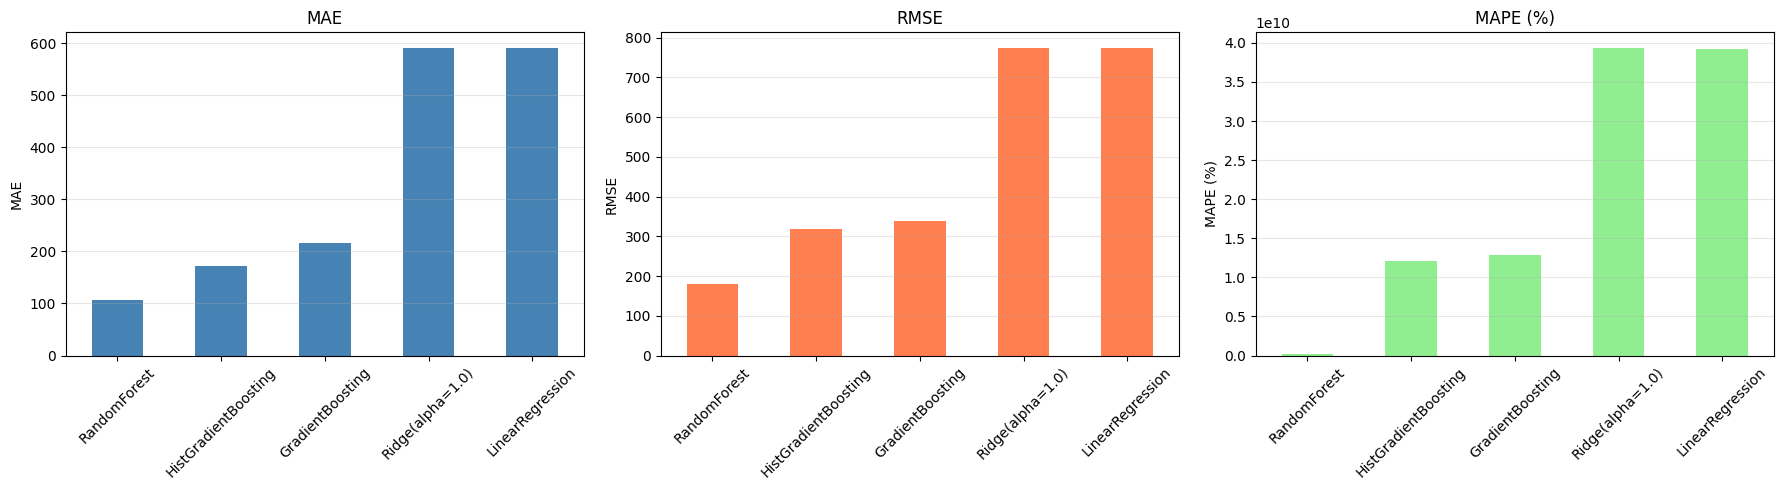

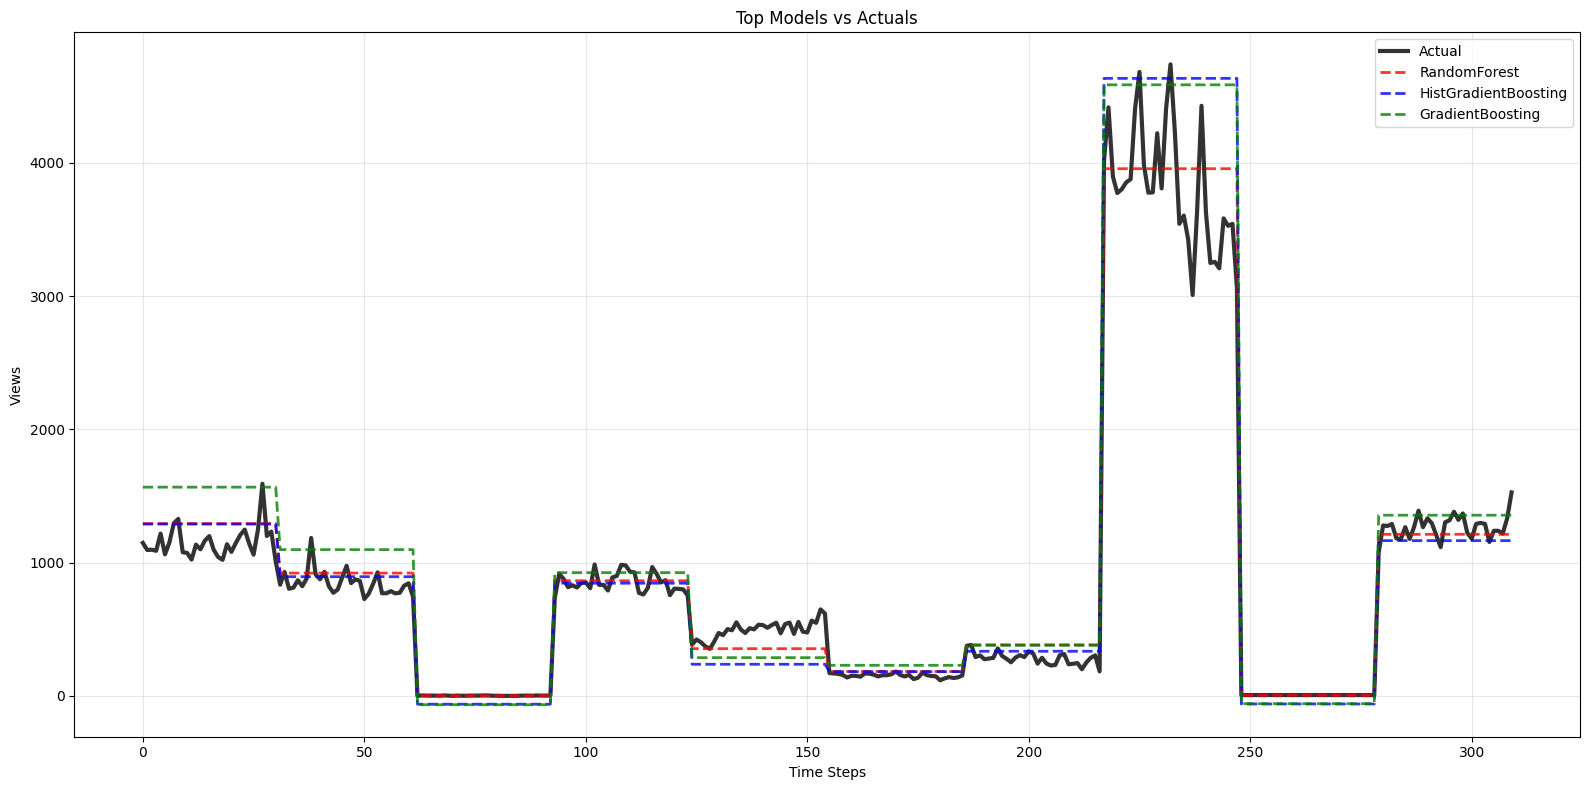

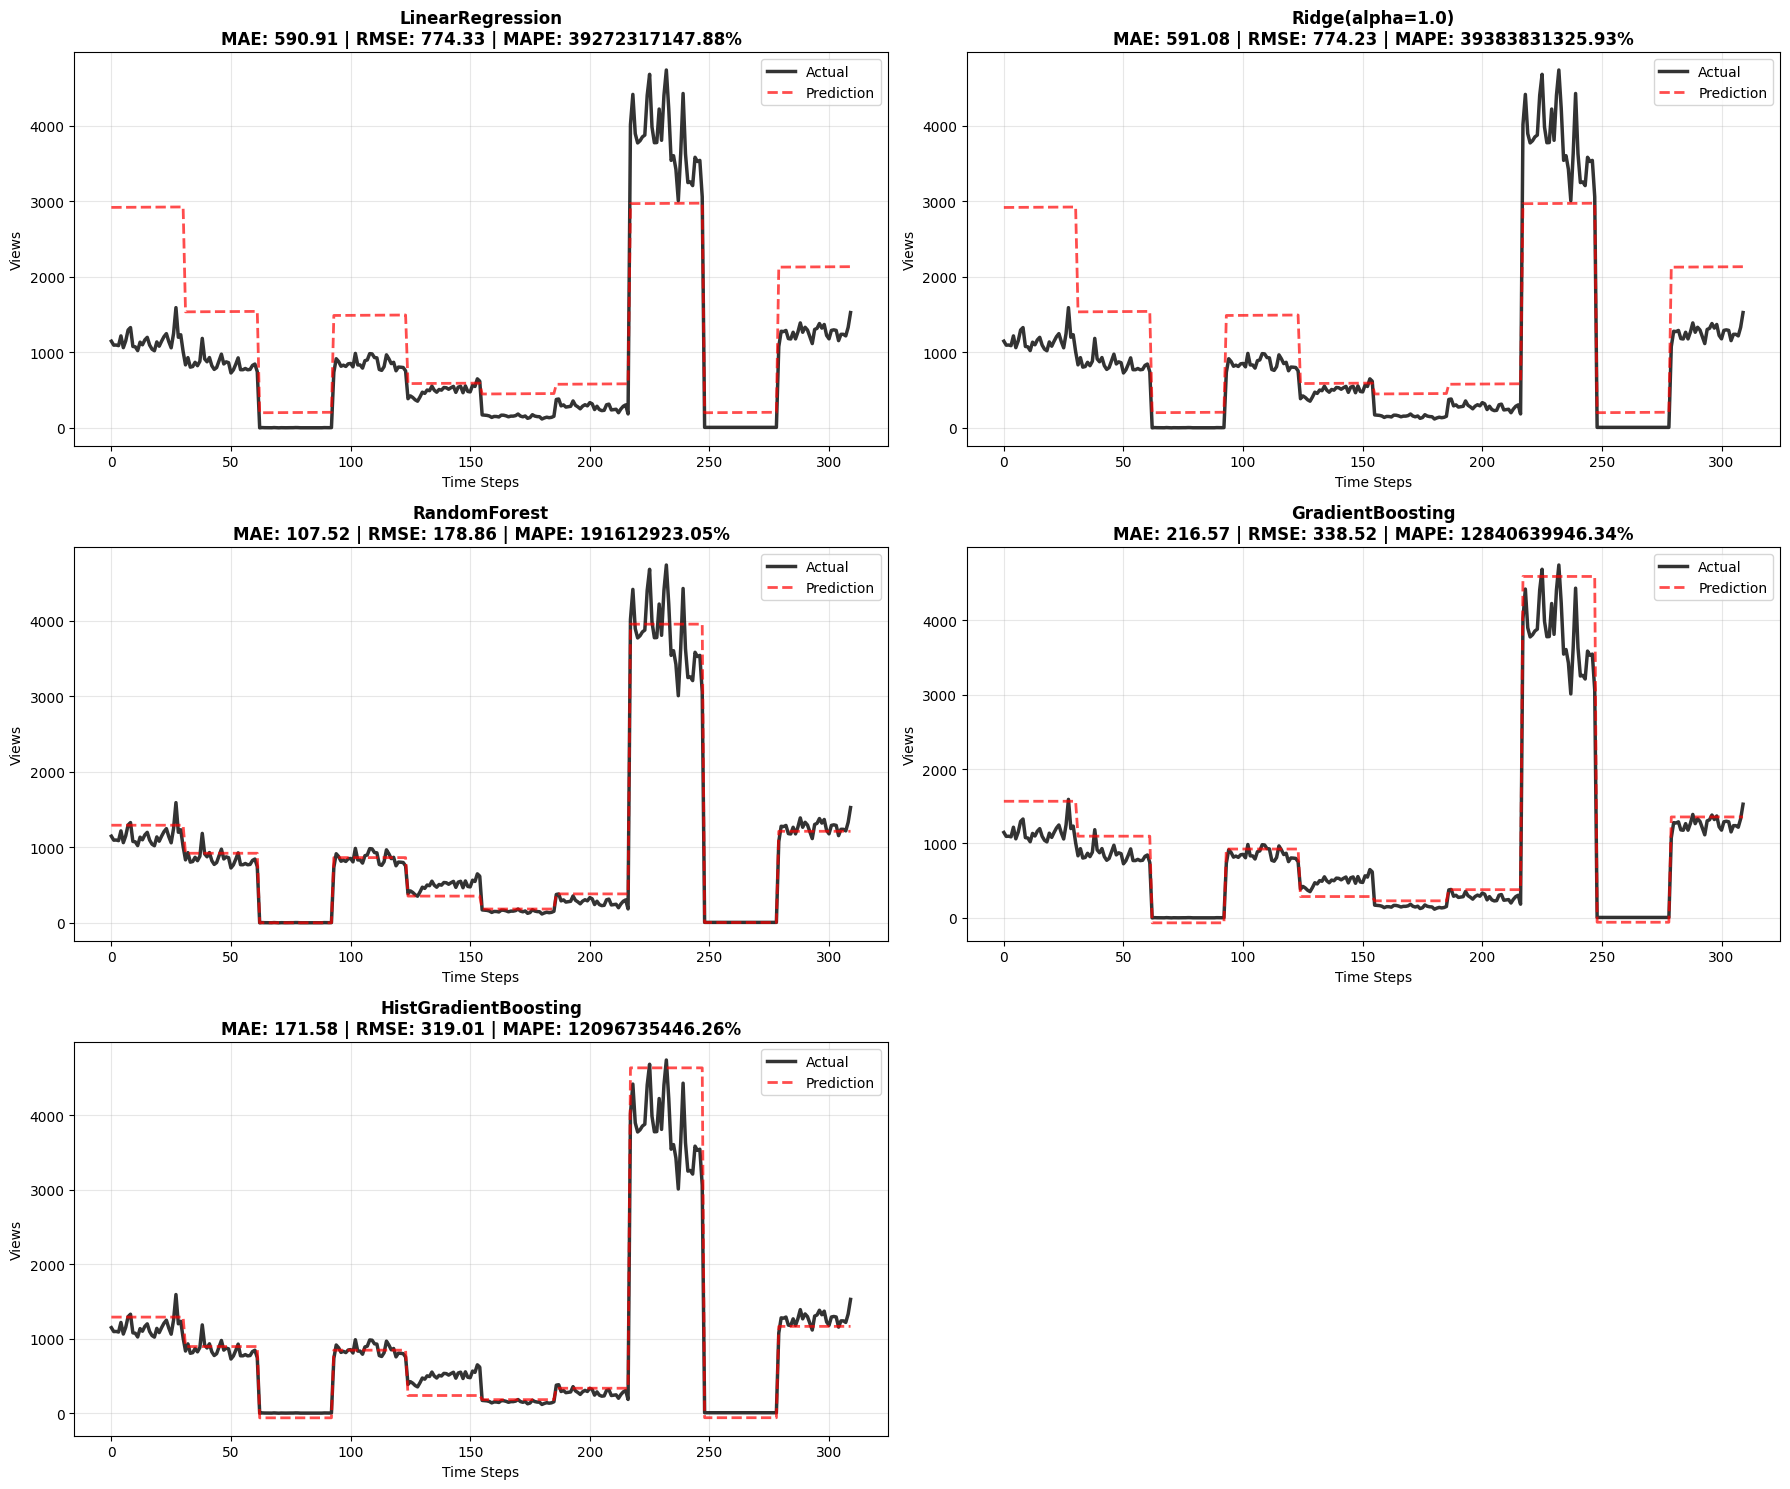

In [45]:
# None
features = get_features(none_train)
none = train_models_ml(none_train, none_test, target_col="y", feature_cols=features)
comp_df = model_comparison(none[0])
visualisation_top_models(comp_df=comp_df, y_test=none[2], preds_store=none[1])
individual_comp(none[1], none[2], none[0])


MODEL COMPARISON (lower is better):
                             MAE        RMSE                MAPE
RandomForest          137.729156  250.905206    303817228.331799
HistGradientBoosting  182.037206  341.611939  15376858619.331041
GradientBoosting      219.962629  377.495386  10221353608.369688
Ridge(alpha=1.0)      589.462354  774.515065  35425192890.505714
LinearRegression      589.293544   774.61307  35313265923.567566


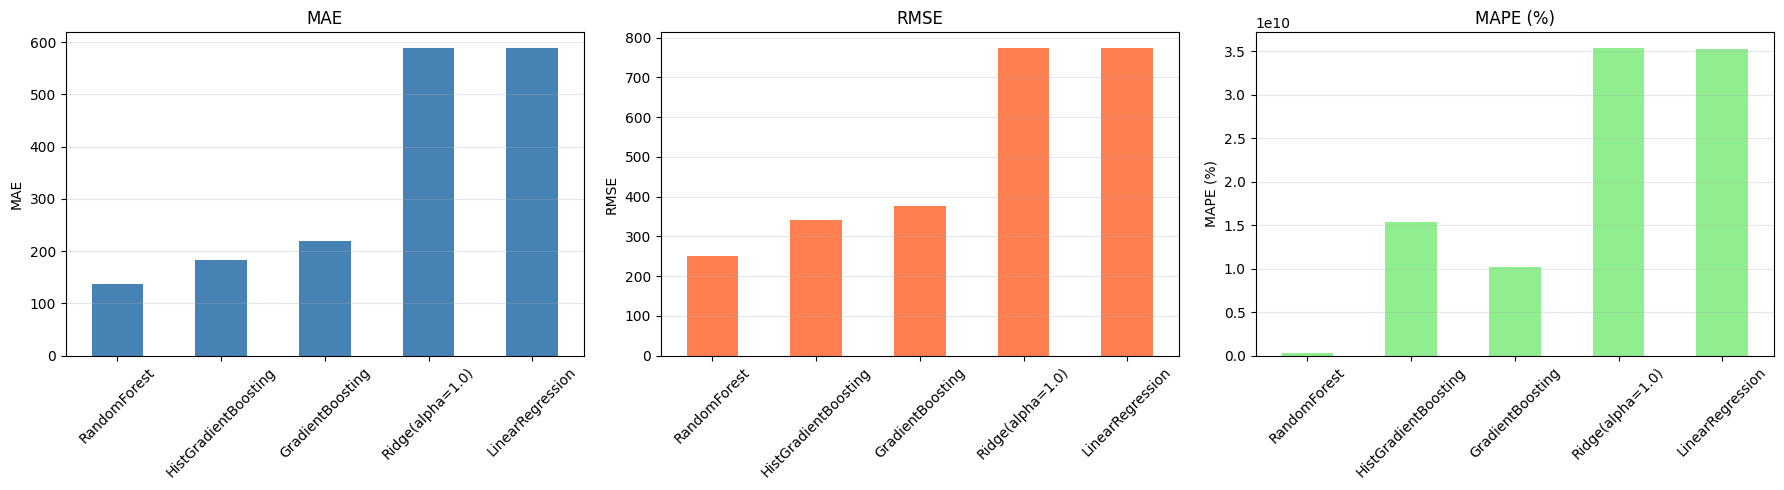

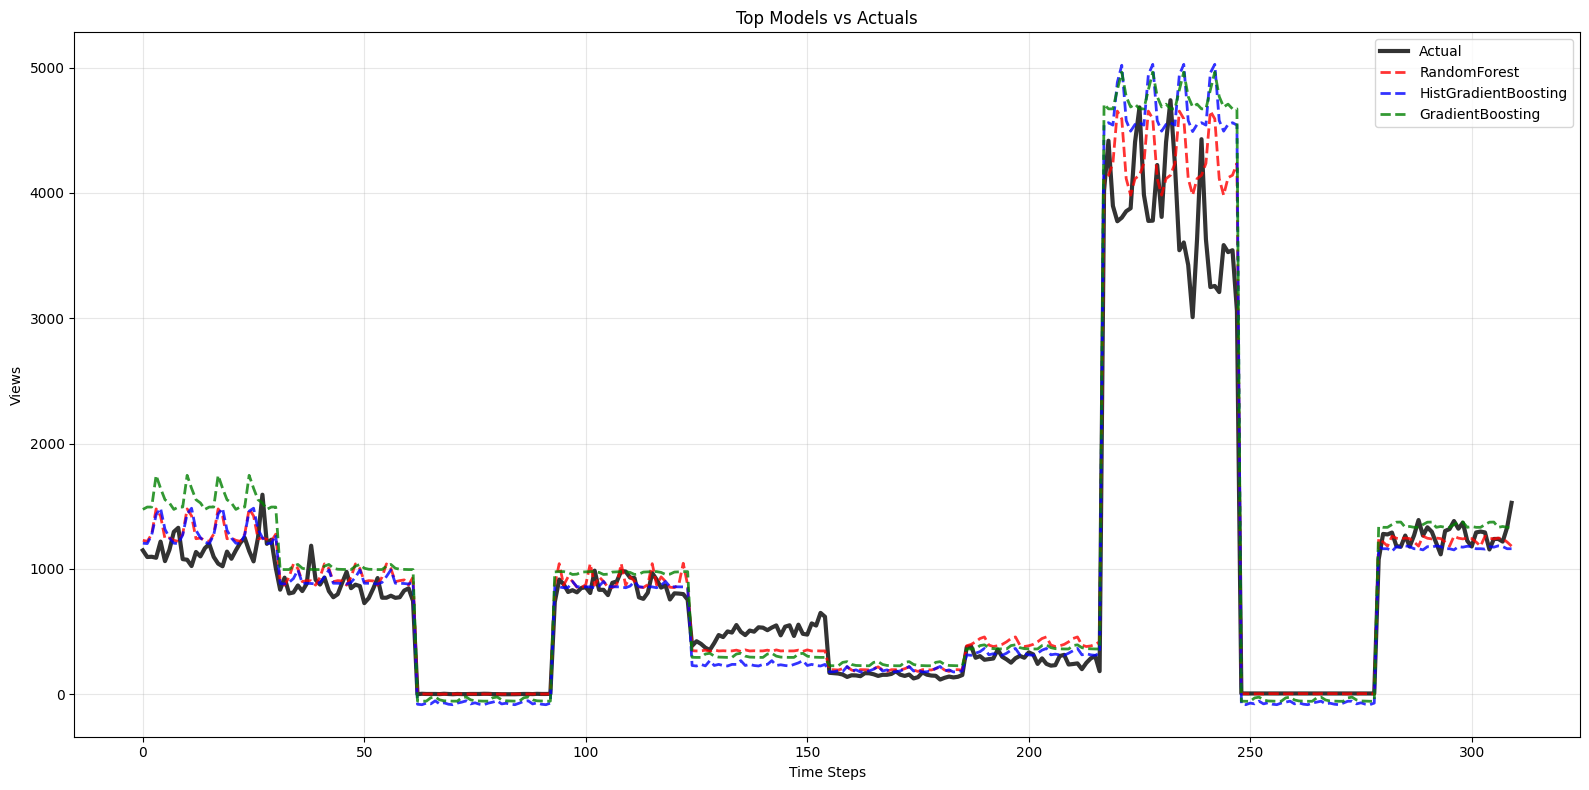

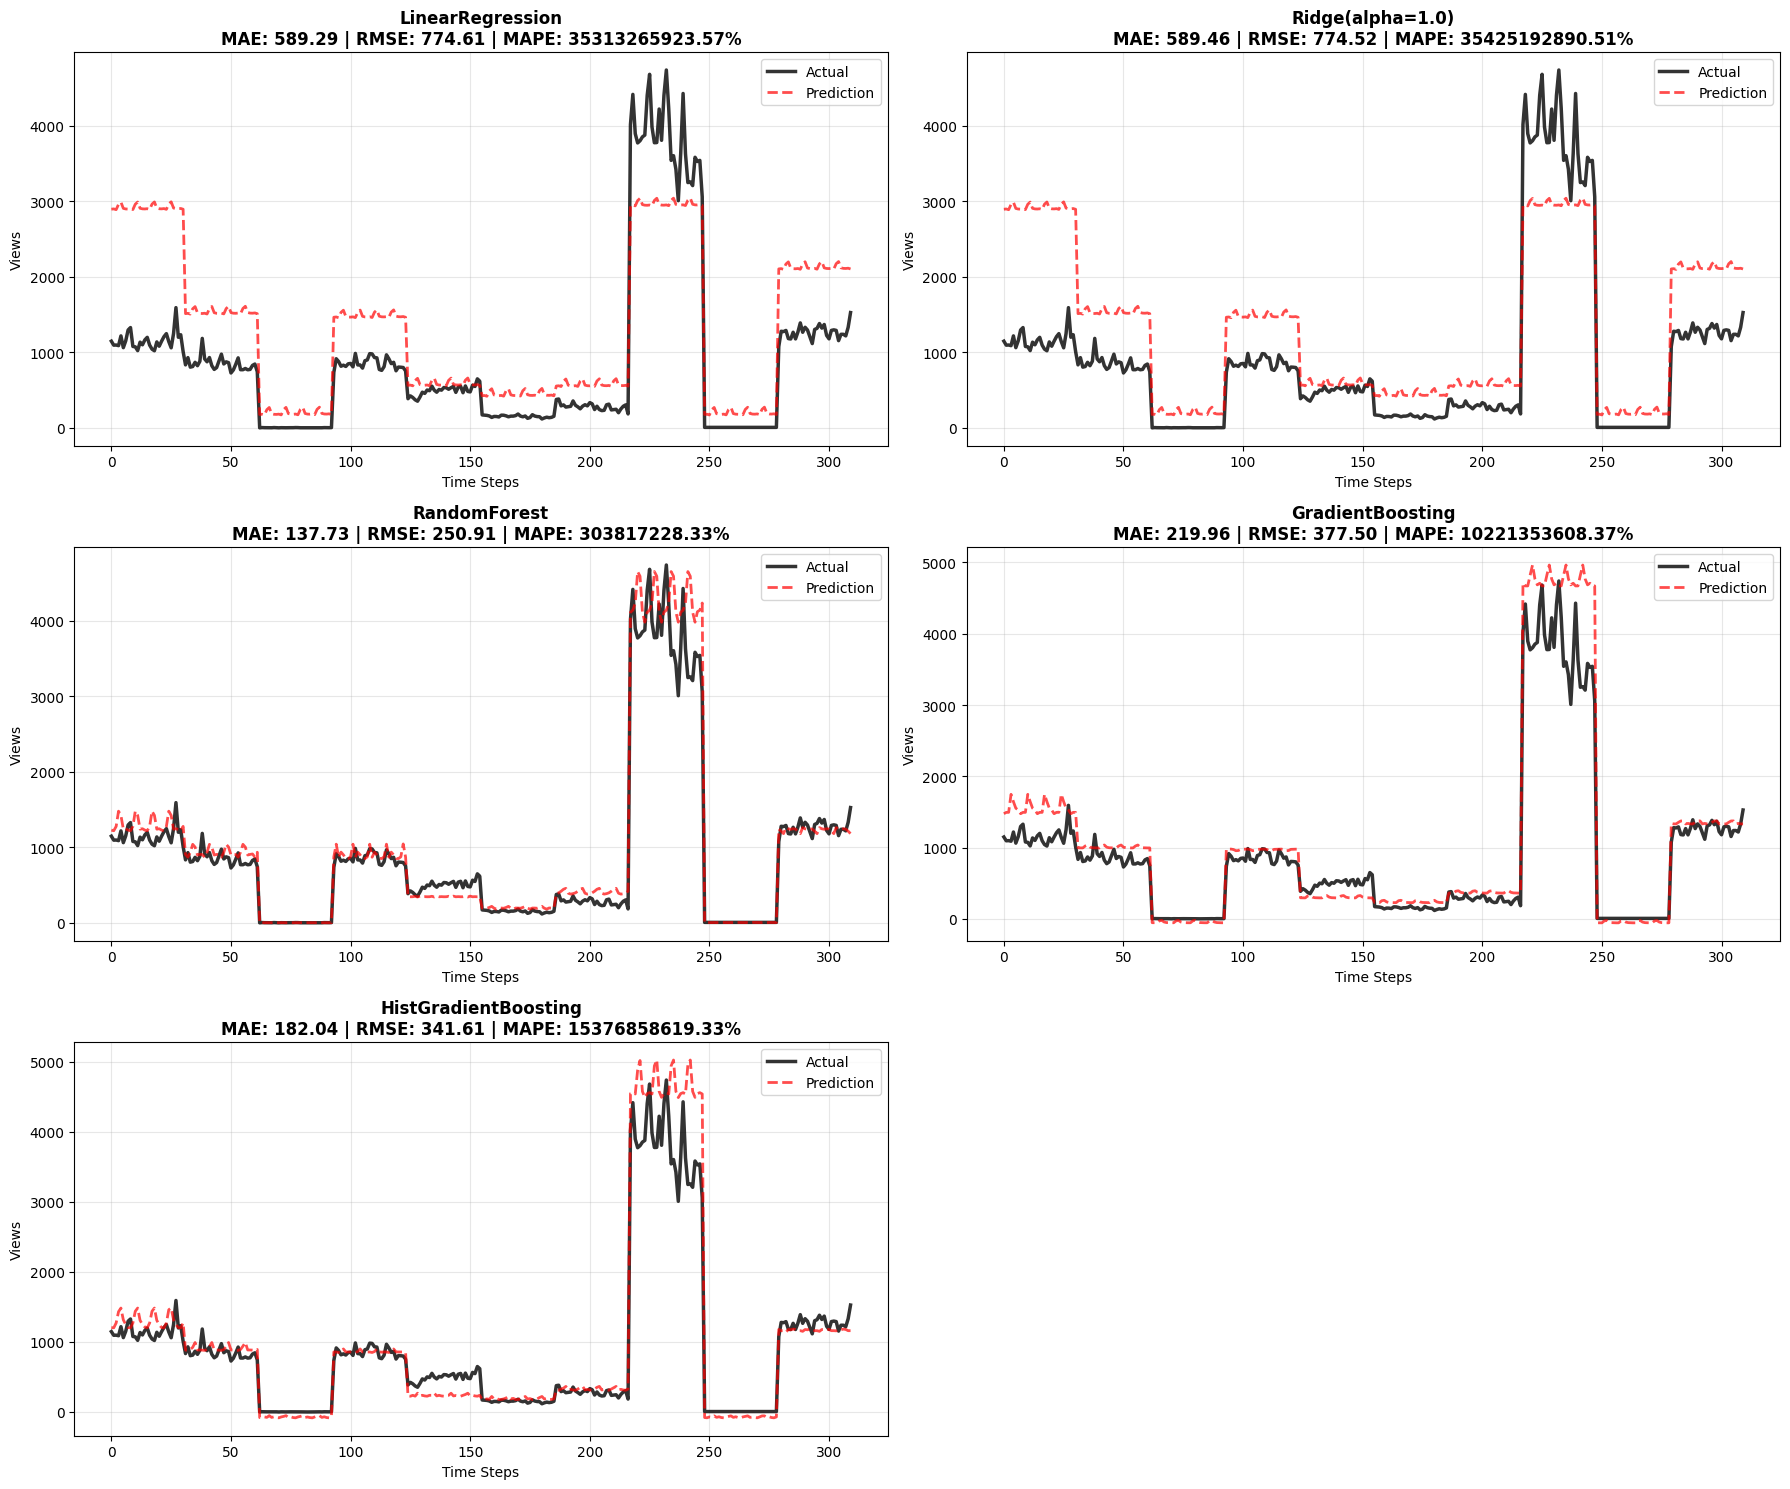

In [43]:
# Fourier
features_f = get_features(fourier_train)
fourier = train_models_ml(fourier_train, fourier_test, target_col = "y", feature_cols =features_f)
comp_df = model_comparison(fourier[0])
visualisation_top_models(comp_df=comp_df, y_test = fourier[2], preds_store=fourier[1])
individual_comp(fourier[1], fourier[2], fourier[0])


MODEL COMPARISON (lower is better):
                             MAE        RMSE                MAPE
RandomForest          134.494688  221.832037    180967765.641661
GradientBoosting      199.162301  326.943729   9912640913.579994
HistGradientBoosting  175.565831  332.093925   5360033845.492483
Ridge(alpha=1.0)      582.268665   768.21635  36819881132.937347
LinearRegression        582.1346  768.341613  36709737805.823265


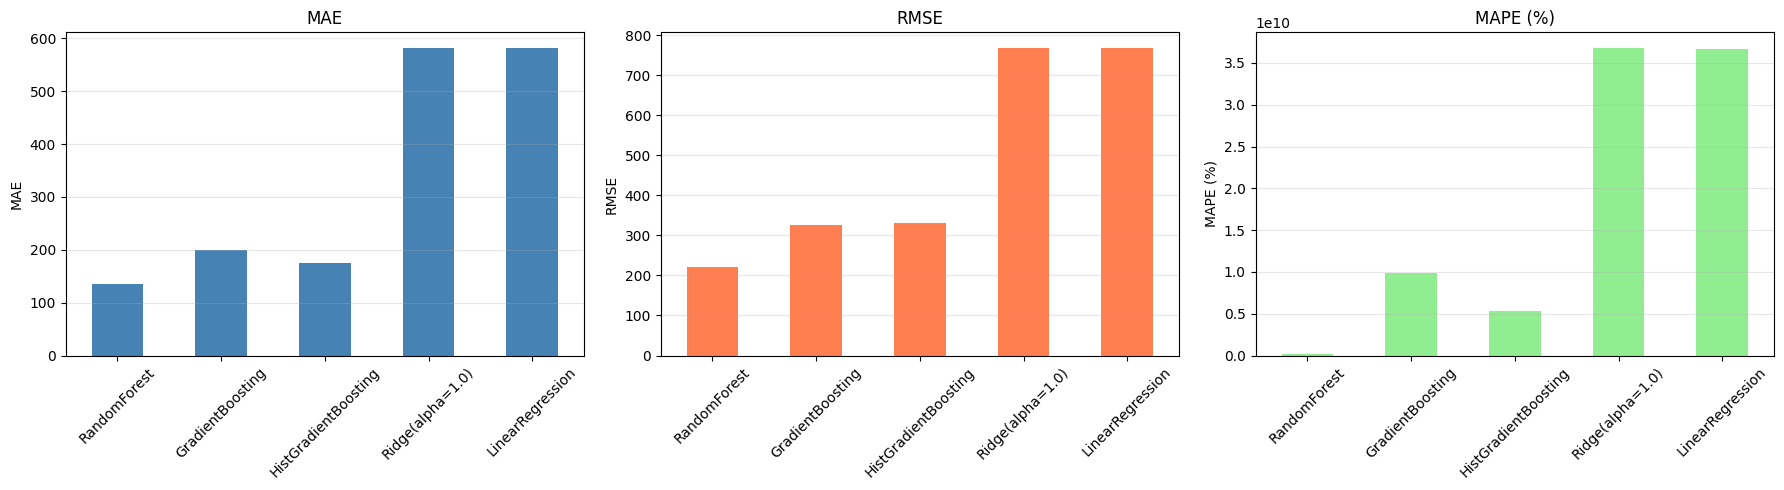

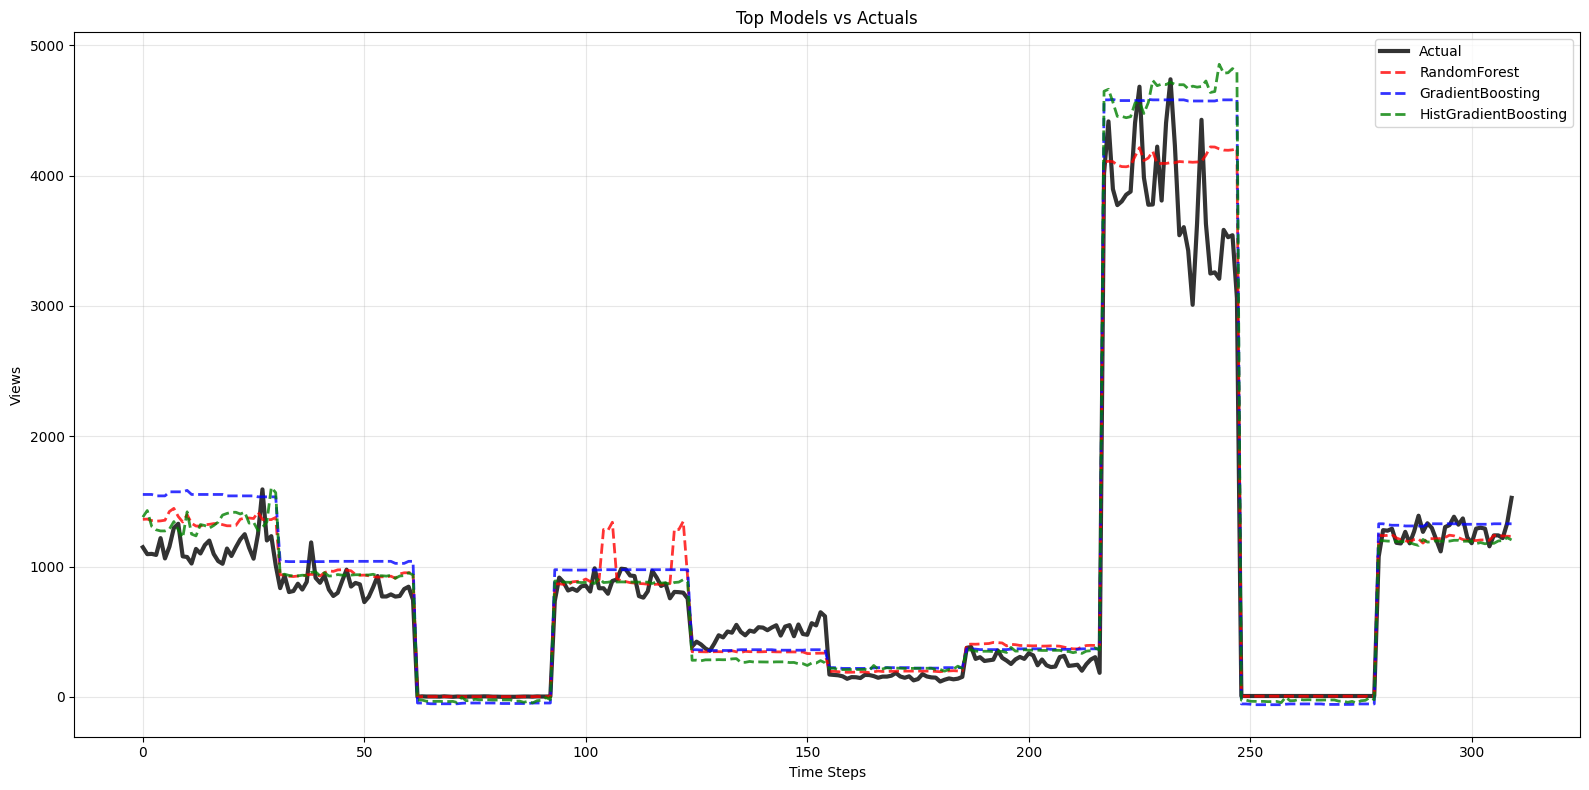

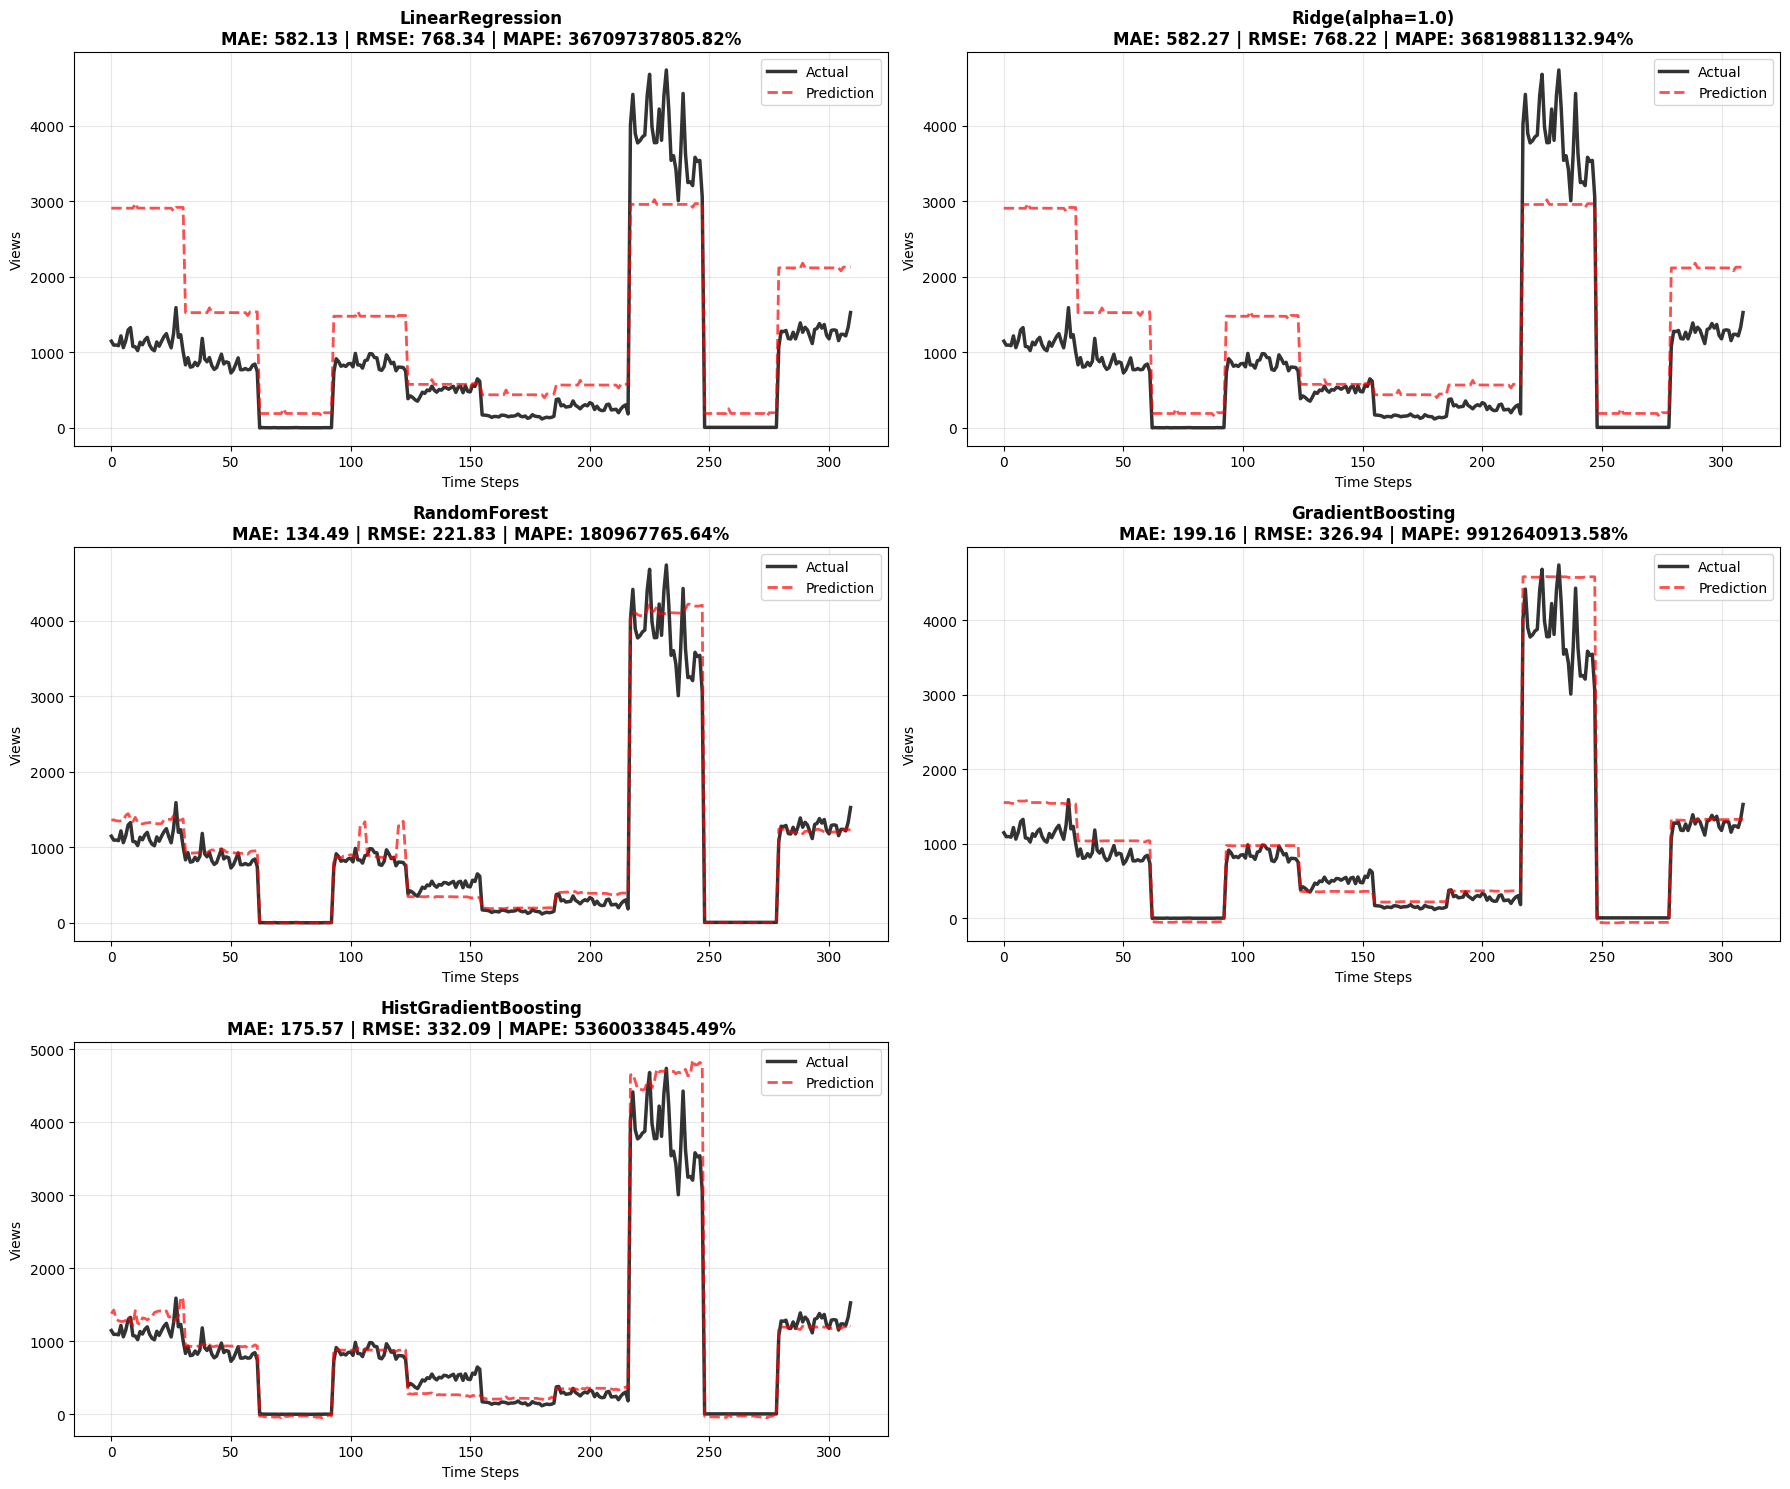

In [44]:
# Holidays
features_h = get_features(holidays_train)
holidays = train_models_ml(holidays_train, holidays_test, target_col="y", feature_cols=features_h)
comp_df = model_comparison(holidays[0])
visualisation_top_models(comp_df=comp_df, y_test=holidays[2], preds_store=holidays[1])
individual_comp(holidays[1], holidays[2], holidays[0])


MODEL COMPARISON (lower is better):
                             MAE        RMSE                MAPE
HistGradientBoosting   171.57744  319.010966  12096735446.262272
GradientBoosting       303.45351  460.568039    865884597.837269
RandomForest          385.281113  622.628853    333010808.101286
Ridge(alpha=1.0)      449.792427  650.473544  35622437372.822464
LinearRegression      450.086423  650.590098  35733957644.118034


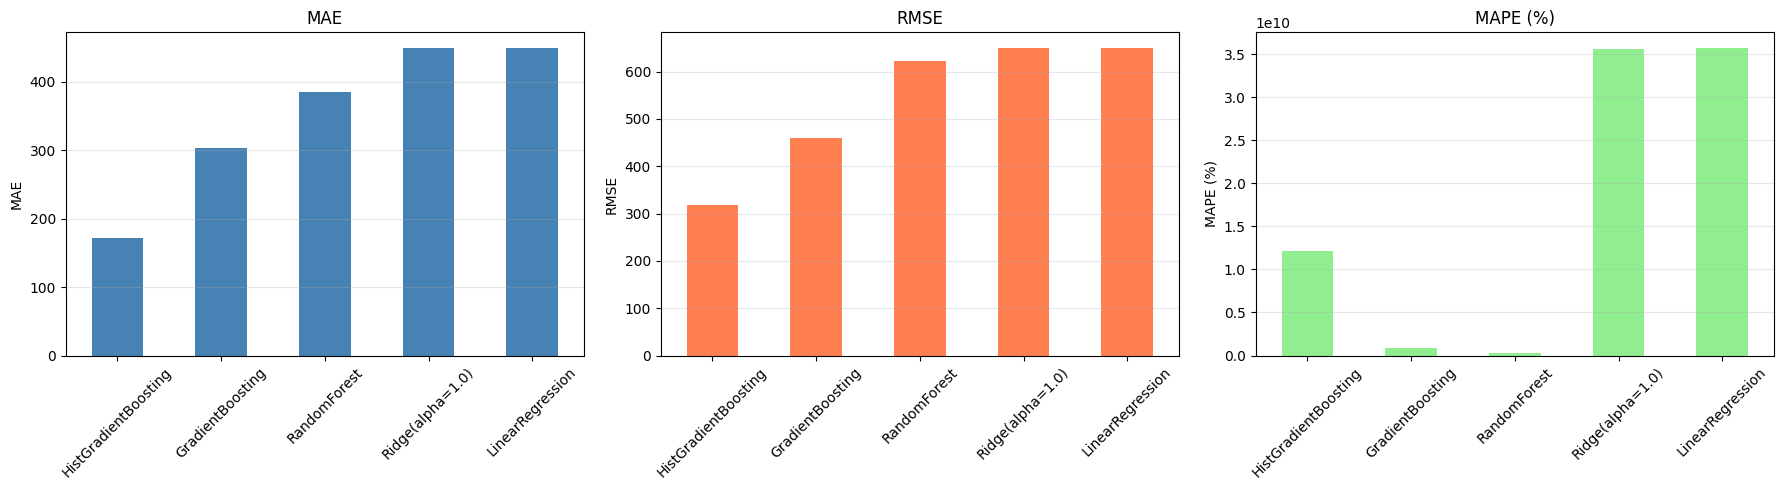

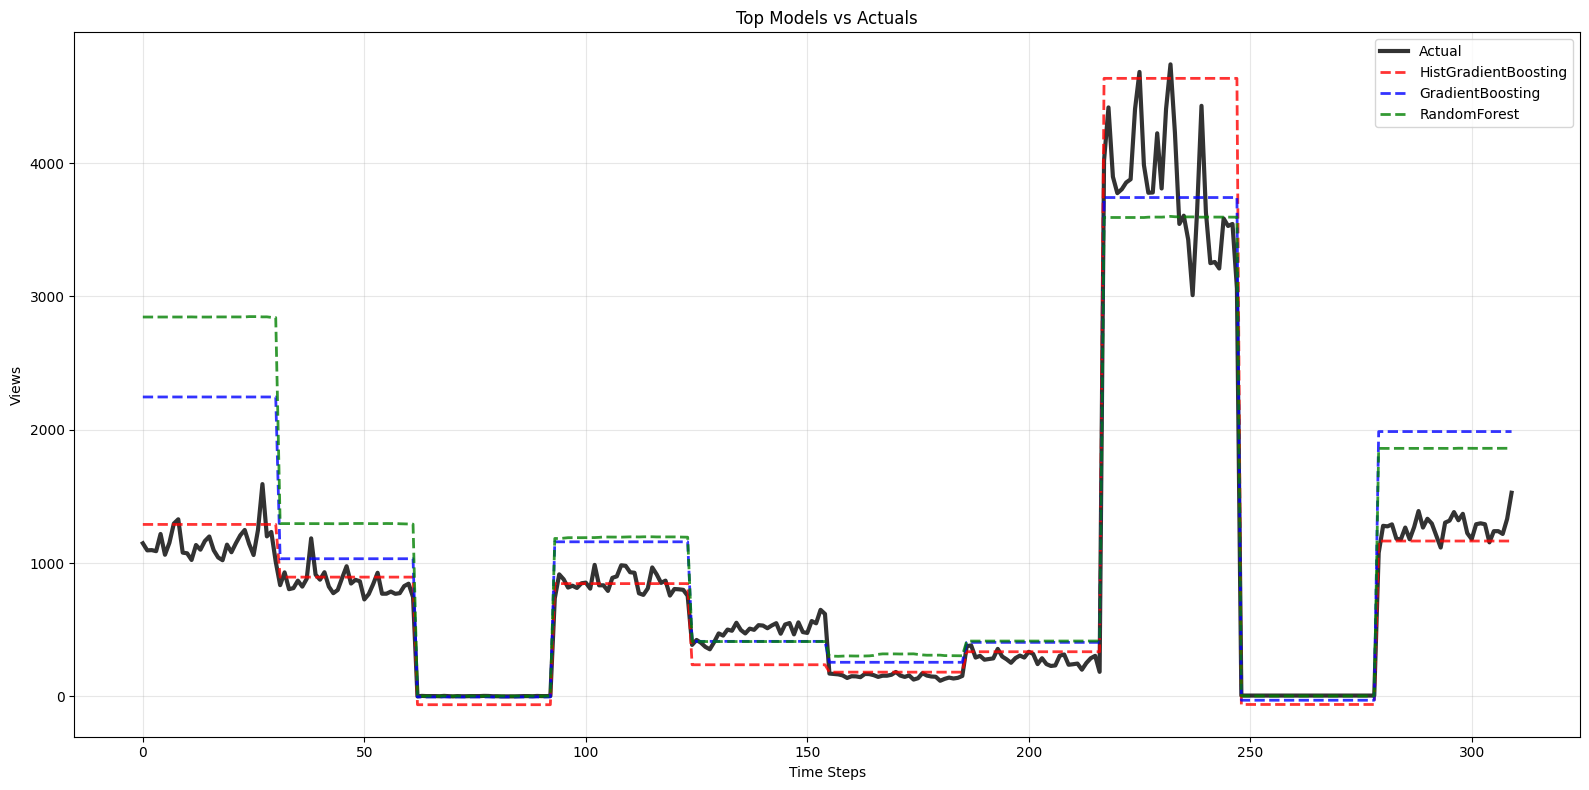

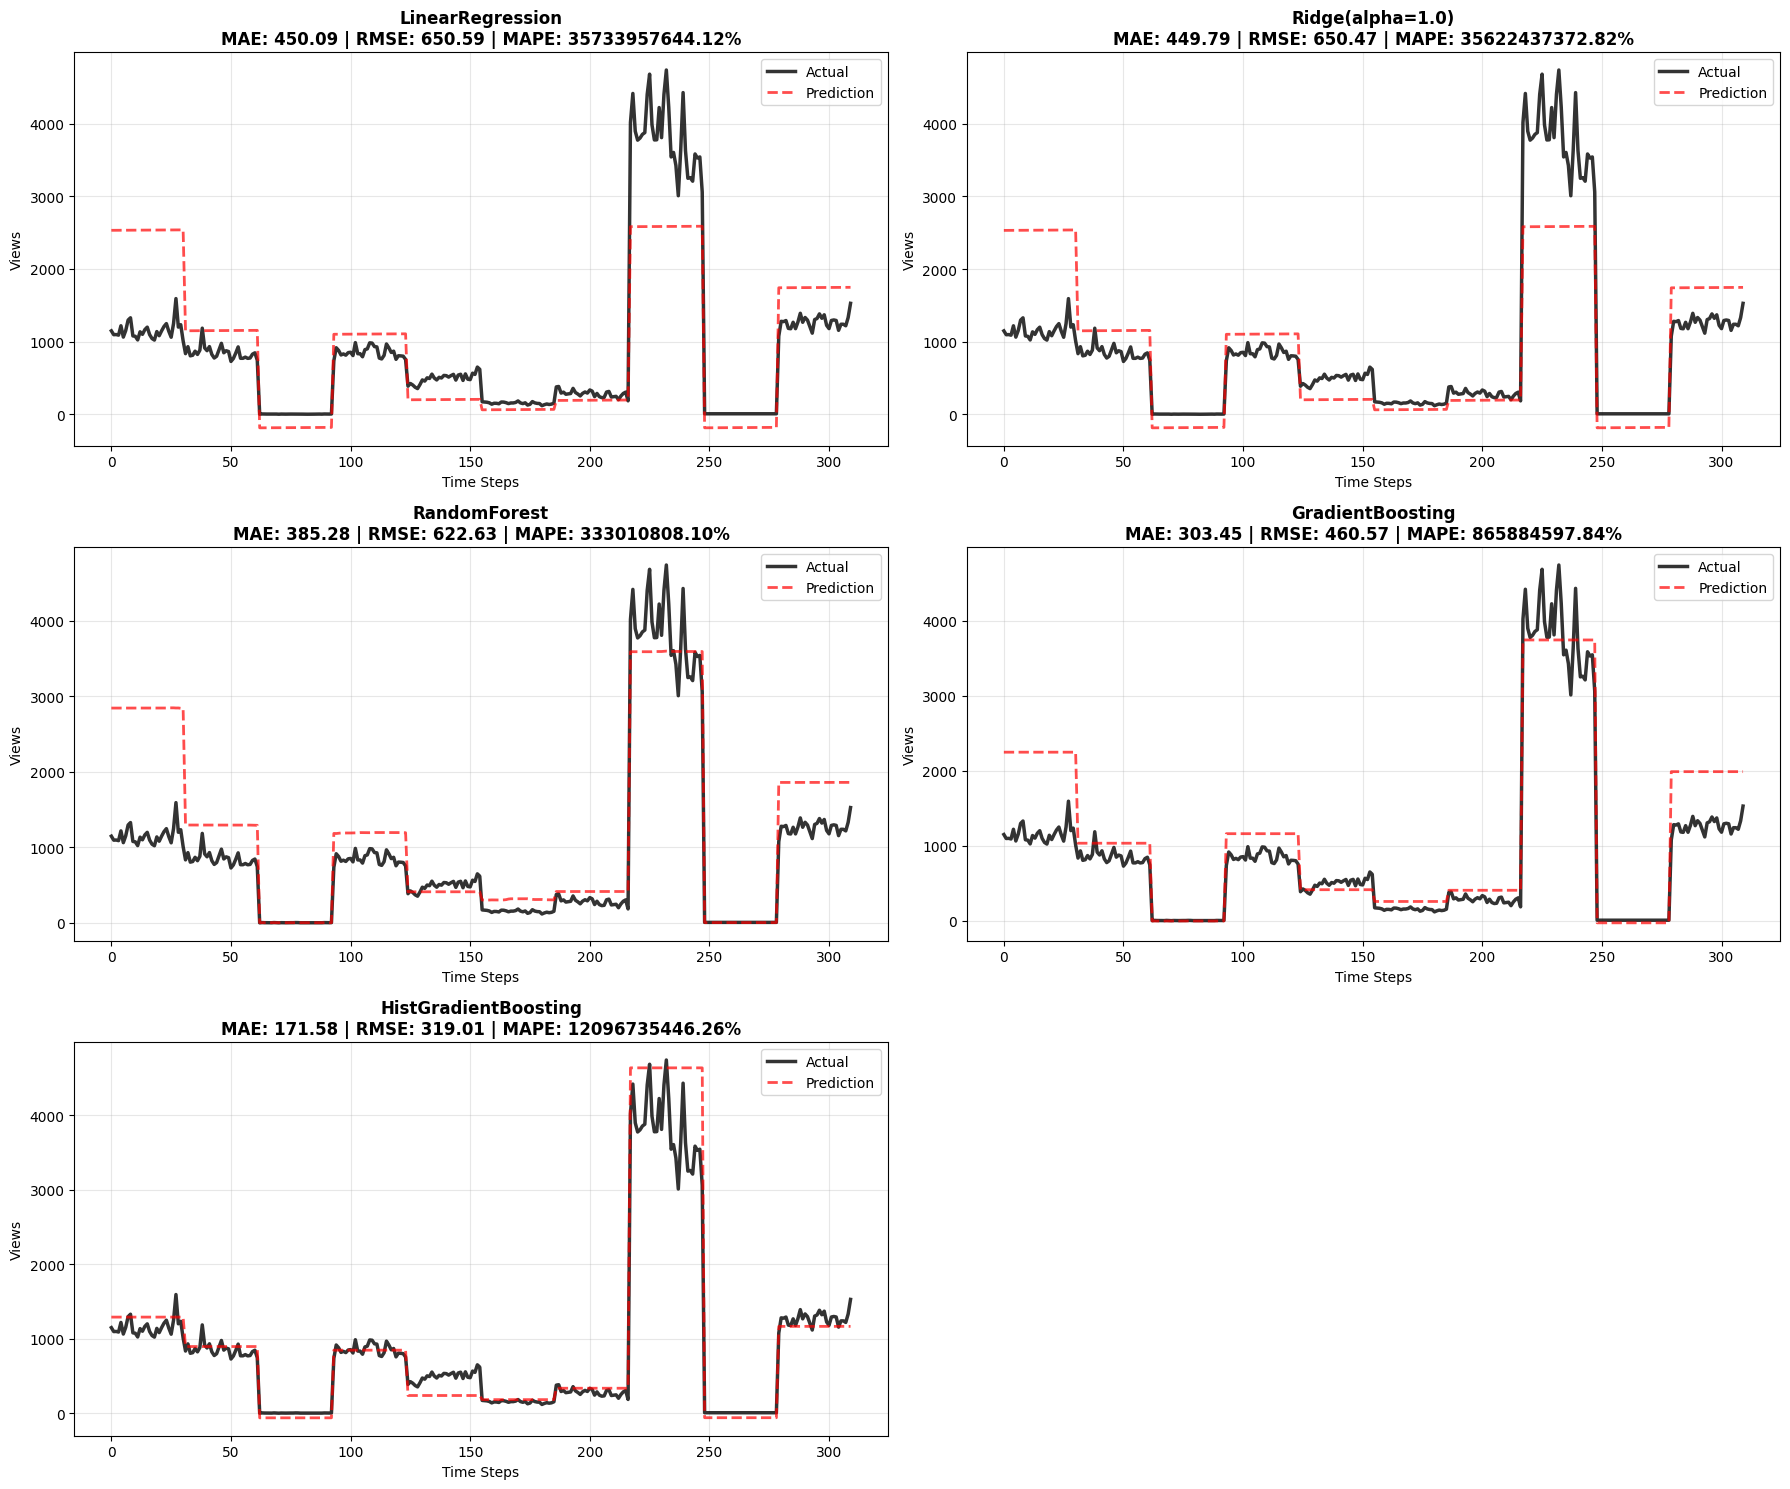

In [46]:
# Trends
features_t = get_features(trend_train)
trends = train_models_ml(trend_train, trend_test, target_col="y", feature_cols=features_t)
comp_df = model_comparison(trends[0])
visualisation_top_models(comp_df=comp_df, y_test=trends[2], preds_store=trends[1])
individual_comp(trends[1], trends[2], trends[0])


MODEL COMPARISON (lower is better):
                             MAE        RMSE                MAPE
HistGradientBoosting  180.641755  344.028161  11619255228.177462
GradientBoosting      325.618226   507.91797   7326508757.056838
RandomForest           340.55714  523.494812    322365642.087403
Ridge(alpha=1.0)      452.790492  652.076287  42234219931.607933
LinearRegression      453.082054  652.203625  42341175958.043846


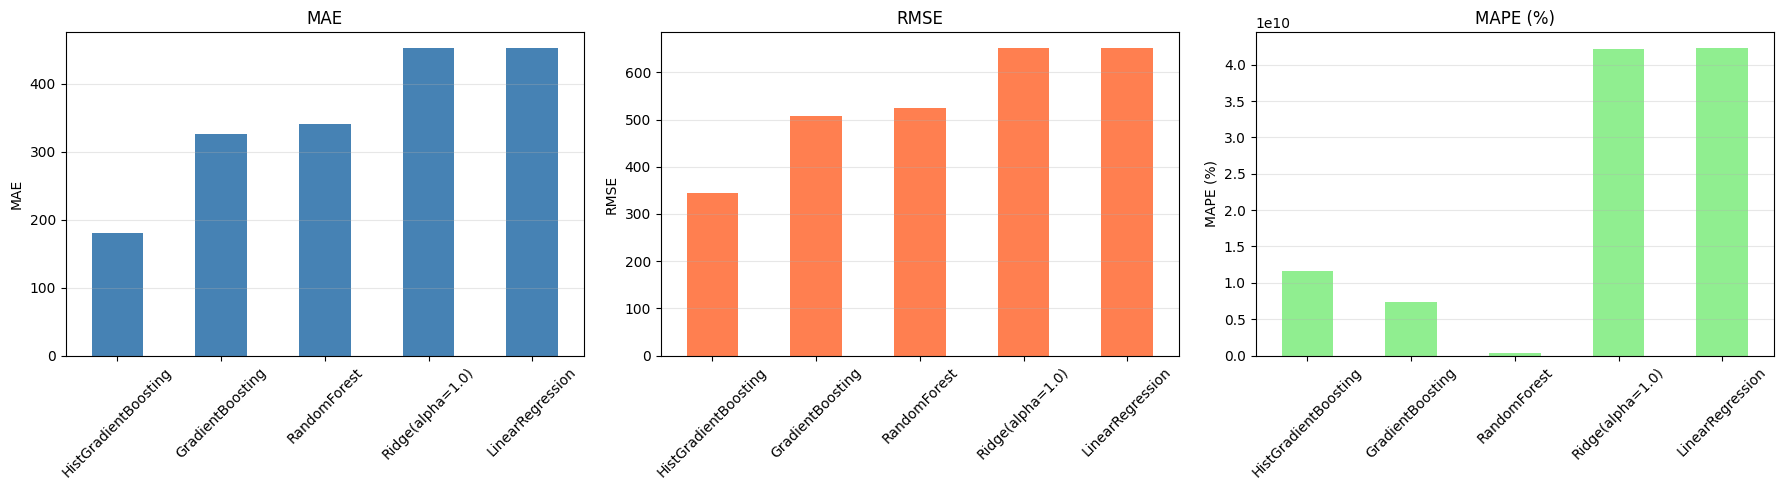

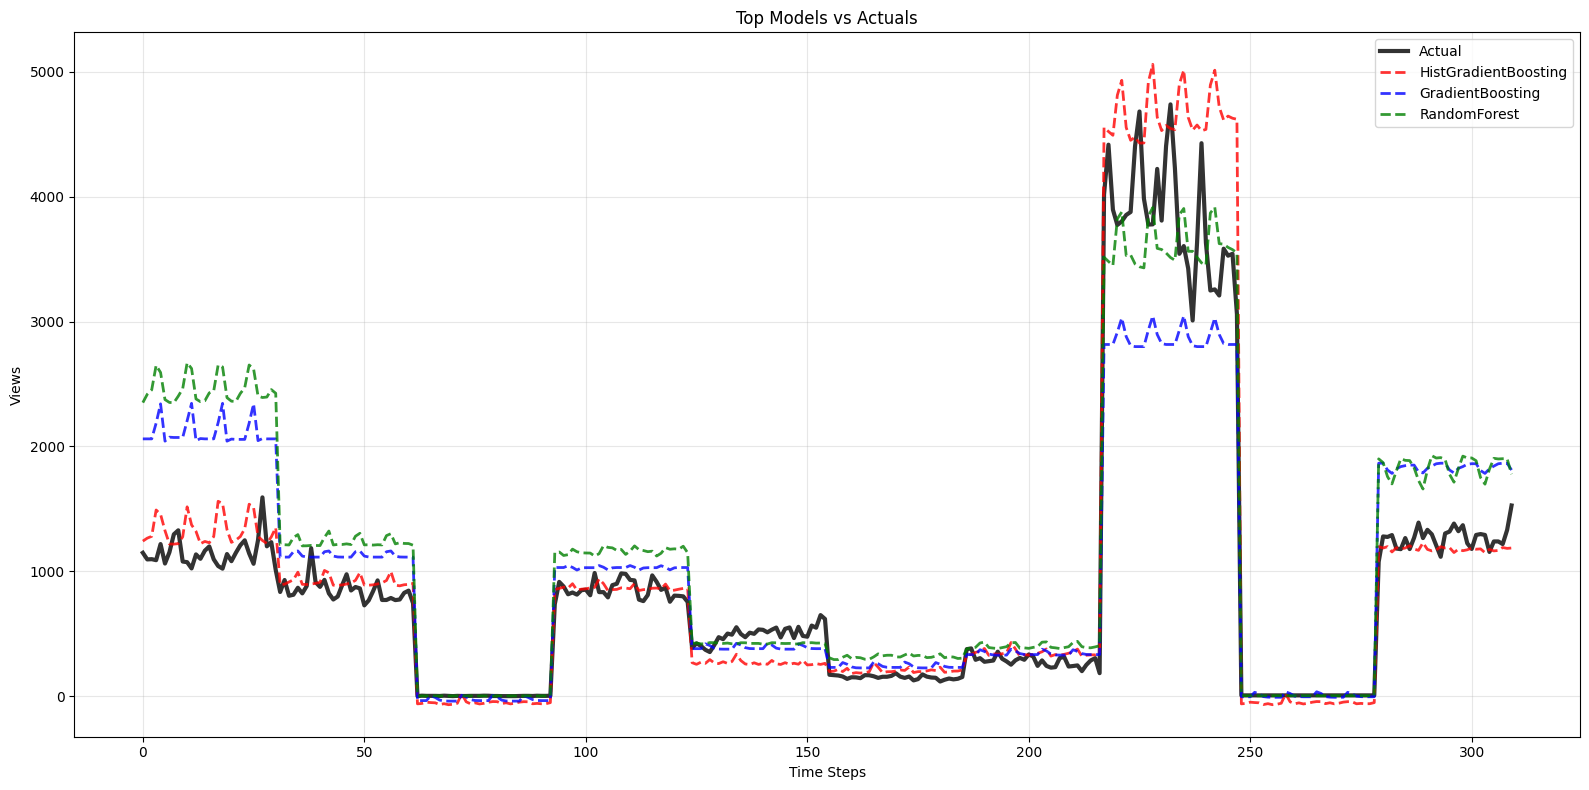

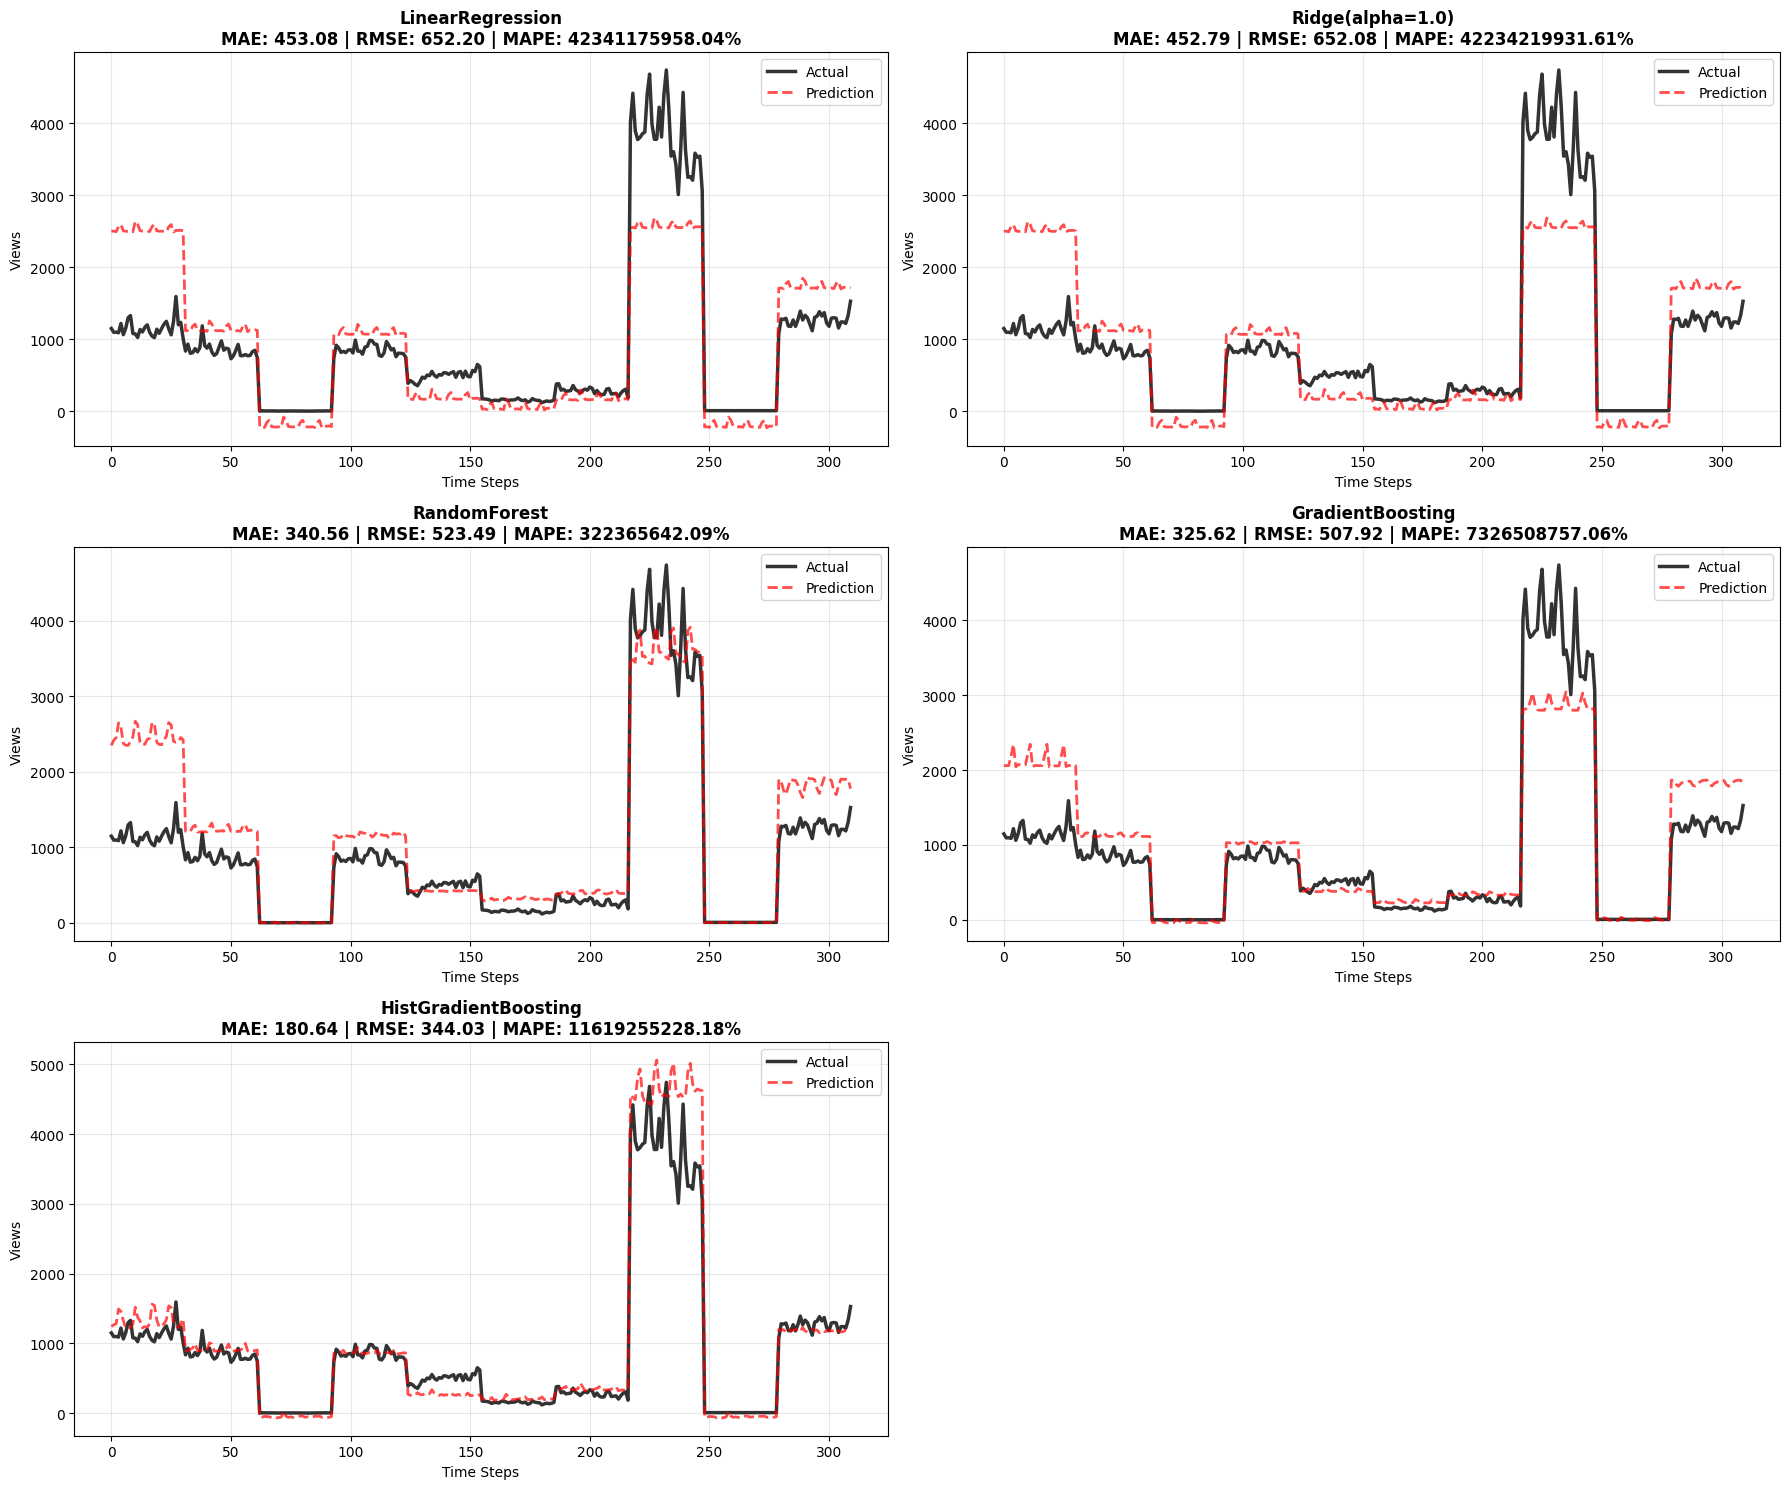

In [47]:
# Fourier + Trends + Holidays
features_fth = get_features(fth_train)
fth = train_models_ml(fth_train, fth_test, target_col="y", feature_cols=features_fth)
comp_df = model_comparison(fth[0])
visualisation_top_models(comp_df=comp_df, y_test=fth[2], preds_store=fth[1])
individual_comp(fth[1], fth[2], fth[0])